# Data Science Project: Predicting Usage of a Video Game Research Server

**_______________________________________________________________________________________________________________________________**

## Predicting Whether a Player's Age Determines Their Subscription to Game-Related Newsletters

### Introduction

At UBC, a research group led by Frank Wood collected data on people playing video games, specifically Minecraft. Minecraft is a popular game played by millions of people worldwide. Many players often become hooked on Minecraft and stay hooked through newsletters. Newsletters are emails that are sent to players to share news about updates and special offers, encouraging them to buy items and continue playing. However, subscribing to these newsletters is optional. 

The question we want to answer is: **Can a player's age predict whether they will subscribe to Minecraft emails and newsletters in the `players.csv` dataset?**

The data  collected includes: 
- Players' experience (`experience`)
- Whether they subscribed to receive game-related newsletters (`subscribe`)
- Players' email (`hashedEmail`)
- The number of hours players play Minecraft (`played_hours`)
- The players' name (`name`)
- The players' gender (`gender`)
- The players' age (`Age`)

Note that some variables contain missing information for certain players (e.g., N/A). These missing values must be addressed and removed when cleaning the data. 

### Methods & Results

In [1]:
#Run cell
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data <- read_csv("Data/players.csv")
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
players_data_clean <- players_data |>
    select(subscribe, Age) |>
    mutate(subscribe = as_factor(subscribe)) |>
    drop_na()
players_data_clean

subscribe,Age
<fct>,<dbl>
TRUE,9
TRUE,17
FALSE,17
⋮,⋮
FALSE,22
FALSE,17
FALSE,17


In [57]:
players_data_summary <- players_data_clean |>
    group_by(subscribe) |>
    summarize(mean_age = mean(Age), med_age = median(Age))
players_data_summary

subscribe,mean_age,med_age
<fct>,<dbl>,<dbl>
FALSE,22.98077,21
TRUE,19.61972,18


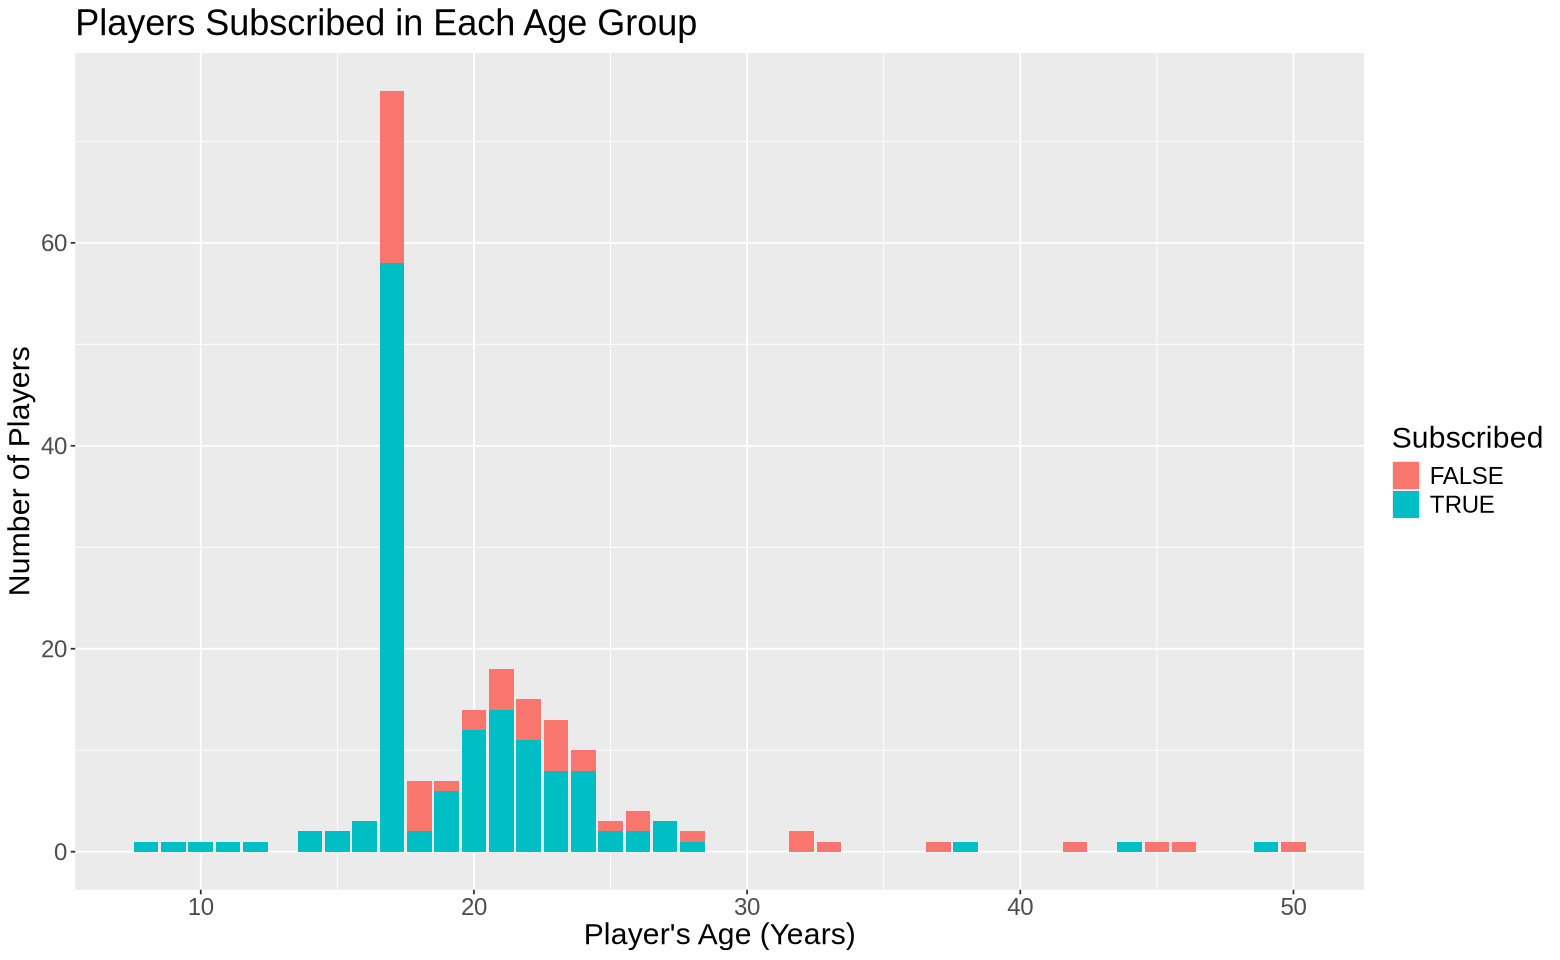

In [59]:
player_data_clean_plot <- players_data_clean |>
    ggplot(aes(x = Age, fill = subscribe)) +
    geom_bar(stat = "count") +
    labs(x = "Player's Age (Years)", y = "Number of Players", fill = "Subscribed") +
    ggtitle("Players Subscribed in Each Age Group") +
    theme(text = element_text(size = 18))
player_data_clean_plot

In [29]:
set.seed(1000)

players_split <- initial_split(players_data_clean, prop = 0.75, strata = subscribe) 
players_train <- training(players_split) 
players_test <- testing(players_split)

In [30]:
players_recipe <- recipe(subscribe ~ Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [31]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [32]:
training_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [33]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

In [34]:
train_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = training_vfold, grid = k_vals) |>
    collect_metrics()
train_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3169130,5,0.02645666,Preprocessor1_Model01
1,roc_auc,binary,0.4674242,5,0.03501448,Preprocessor1_Model01
2,accuracy,binary,0.3169130,5,0.02645666,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.3936959,5,0.06014271,Preprocessor1_Model09
10,accuracy,binary,0.4063875,5,0.04657670,Preprocessor1_Model10
10,roc_auc,binary,0.3831749,5,0.06059667,Preprocessor1_Model10


In [35]:
accuracies <- train_workflow |> 
       filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3169130,5,0.02645666,Preprocessor1_Model01
2,accuracy,binary,0.3169130,5,0.02645666,Preprocessor1_Model02
3,accuracy,binary,0.3982594,5,0.05708483,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.3568801,5,0.05982796,Preprocessor1_Model08
9,accuracy,binary,0.4128243,5,0.05307571,Preprocessor1_Model09
10,accuracy,binary,0.4063875,5,0.04657670,Preprocessor1_Model10


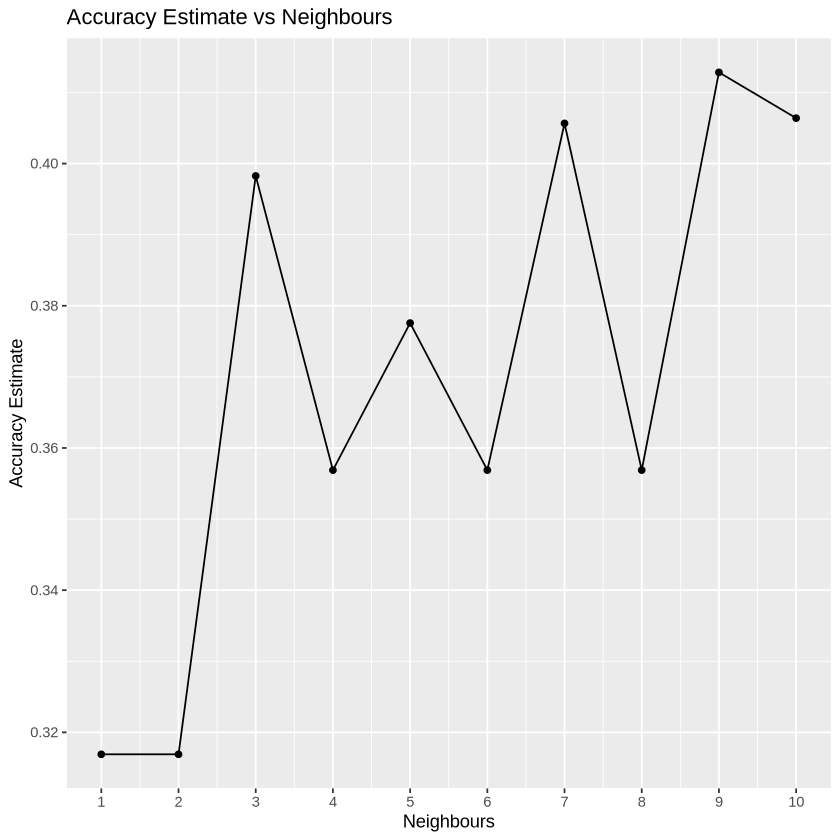

In [36]:
accuracy_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Estimate", title = "Accuracy Estimate vs Neighbours") +
    scale_x_continuous(breaks = seq(1, 10, by = 1))  
accuracy_plot

In [42]:
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

In [44]:
best_knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(best_knn_spec) |>
    fit(data = players_train)
best_knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5172414
Best kernel: rectangular
Best k: 9

In [47]:
knn_predictions <- predict(best_knn_fit, players_test) |>
    bind_cols(players_test)

In [49]:
knn_metrics <- knn_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)|>
    filter(.metric == "accuracy")
knn_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5510204


In [51]:
knn_conf_mat <- knn_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
knn_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     5   14
     TRUE      8   22